# Computer Vision 

In this notebook, we create an initial version of SNGP, spectral normalized neural gaussian process for computer vision. We take the implementation or resnet18 proposed by the original authors of the convoluational architecture and implement a version of SNGP with this base network. We then run intial binary classification and OOD detection experiments on the benchmark CIFAR-10 dataset. We compare accuracy results to a non-residual and non-deep architecture and summarize.

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from functools import partial
from dataclasses import dataclass

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

## ResNet network and GP Layer (SNGP)

Below is first an implementation of the ResNet Pytorch infastructure. We alter it to make a more lightweight architecture for training and experimentation time purposes. We also add spectral normalization. 

Following our ResNet on Pytorch Implementation, we add this to our GP layer implementation for a final model to implement.


In [ ]:
from collections import OrderedDict

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.utils.spectral_norm(nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False)),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 128, 256], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False)),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.utils.spectral_norm(nn.Linear(in_features, n_classes))

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])


In [ ]:
class Net(nn.Module):

    def __init__(self,latent_space_dim, rff_count):
        super(Net, self).__init__()
        # MLP
        self.latent_space_dim = latent_space_dim
        self.rff_count = rff_count
        self.D_L = torch.tensor(rff_count)
        # self.dim_increase = nn.utils.spectral_norm(nn.Linear(2, latent_space_dim))
        # self.dim_decrease = nn.utils.spectral_norm(nn.Linear(256, latent_space_dim))
        self.W = torch.reshape(torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).sample((rff_count,latent_space_dim)), (rff_count,latent_space_dim)) 
        self.b = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([2.0 * math.pi])).sample((rff_count,))
        self.beta_0 = torch.nn.Parameter(torch.randn(rff_count))
        self.beta_1 = torch.nn.Parameter(torch.randn(rff_count))
        self.resnet =  resnet18(3, latent_space_dim)
        #self.fin = nn.utils.spectral_norm(torch.nn.Linear(2,1))
    
    def get_latent_representation(self,x):
        res_result = self.resnet(x)
        return torch.transpose(res_result, 0, 1)
    
    def get_feature(self,x):
        relu1 = self.get_latent_representation(x)
        return torch.sqrt(2 / self.D_L) * torch.cos(torch.matmul(-1 * self.W, relu1) + self.b)
    
    def GP_layer(self, x):
        zero_pred = torch.unsqueeze(torch.sqrt(2 / self.D_L) * torch.matmul(torch.transpose(torch.cos(torch.matmul(-1 * self.W, x) + self.b), 0, 1), self.beta_0), 1)
        one_pred =  torch.unsqueeze(torch.sqrt(2 / self.D_L) * torch.matmul(torch.transpose(torch.cos(torch.matmul(-1 * self.W, x) + self.b), 0, 1), self.beta_1),1)
        out = torch.cat((zero_pred,one_pred), dim=1)
        return out

    def forward(self, x):
        relu1 = self.get_latent_representation(x)
        GP = self.GP_layer(relu1)
        return GP

## Dataset
Below we obtain the CIFAR10 dataset from the torchvision package. For the purposes of today, we only complete a binary classification task on plane and dog. For OOD, we have images derived from ship and car class.

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./data', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='./data', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = trainset.targets
y_test = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

# ================== Usage ================== #

# Let's choose cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
plane_dog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), get_class_i(x_train, y_train, classDict['dog'])],
        transform_with_aug
    )
plane_dog_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['plane']), get_class_i(x_test , y_test , classDict['dog'])],
        transform_no_aug
    )
ship_car_set = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['ship']), get_class_i(x_test , y_test , classDict['car'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(plane_dog_trainset, batch_size=50, shuffle=True , **kwargs)
testsetLoader    = DataLoader(plane_dog_trainset , batch_size=50, shuffle=False, **kwargs)
oodLoader    = DataLoader(ship_car_set , batch_size=64, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


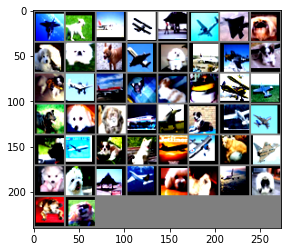

plane   car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainsetLoader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

## Training

We create a model with an RFF of 1024 and a latent feature size of 2. We use Adam to train. Loss results are below.

In [ ]:
import torch.optim as optim

model = Net(2,1024)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainsetLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(labels.shape[0]).long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 500 images
            print('[%d, %10d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            # correct = 0
            # total = 0
            # with torch.no_grad():
            #     for data in trainsetLoader:
            #         images, labels = data
            #         # images, labels = data[0].to(device), data[1].to(device)
            #         outputs = model(images)
            #         _, predicted = torch.max(outputs.data, 1)
            #         total += labels.size(0)
            #         correct += (predicted == labels).sum().item()
            #         break

            # print('Accuracy of the network on the 10000 test images: %d %%' % (
            #     100 * correct / total))

print('Finished Training')

[1,         10] loss: 0.678
[1,         20] loss: 0.624
[1,         30] loss: 0.589
[1,         40] loss: 0.540
[1,         50] loss: 0.478
[1,         60] loss: 0.450
[1,         70] loss: 0.450
[1,         80] loss: 0.530
[1,         90] loss: 0.463
[1,        100] loss: 0.468
[1,        110] loss: 0.377
[1,        120] loss: 0.376
[1,        130] loss: 0.389
[1,        140] loss: 0.331
[1,        150] loss: 0.329
[1,        160] loss: 0.393
[1,        170] loss: 0.305
[1,        180] loss: 0.341
[1,        190] loss: 0.407
[1,        200] loss: 0.522
[2,         10] loss: 0.335
[2,         20] loss: 0.425
[2,         30] loss: 0.333
[2,         40] loss: 0.334
[2,         50] loss: 0.291
[2,         60] loss: 0.299
[2,         70] loss: 0.318
[2,         80] loss: 0.334
[2,         90] loss: 0.317
[2,        100] loss: 0.316
[2,        110] loss: 0.282
[2,        120] loss: 0.434
[2,        130] loss: 0.315
[2,        140] loss: 0.346
[2,        150] loss: 0.291
[2,        160] loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


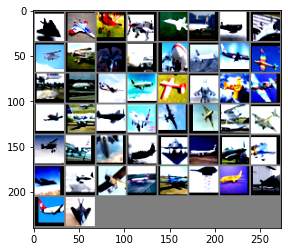

In [ ]:
dataiter = iter(testsetLoader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainsetLoader:
        images, labels = data
        # images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


Ultimately, we recieve an 89% accuracy. This score is not bad, however, considering our large-scale architecture and the intense resources and time that training takes, one would expect better given a binary classification. Moreover, a large search of hyperparameters had to be completed to ultimately achieve high accuracy. While we do gain uncertainty through this, the trade-off is significant.

In [ ]:
def compute_inv_cov(dataset, net, class_num):
    ridge_penalty = 1e-6 # from edward2 codebase; not mentioned in the paper
    # train_ds = TestDataset(dataset)
    train_loader = dataset
    inv_cov = torch.eye(net.rff_count) * ridge_penalty
    for i, batch in enumerate(train_loader):
        estimate = torch.zeros((net.rff_count,net.rff_count))
        inputs, labels = batch
        # print(net.get_feature(inputs))
        features = torch.transpose(net.get_feature(inputs),0,1)
        logits = net(inputs)
        for j in range(labels.shape[0]):
            p = torch.nn.functional.softmax(logits[j].reshape(1,2), 1)
            feature = torch.unsqueeze(features[j],1) # Phi
            k = torch.matmul(feature, torch.transpose(feature,0,1))
            estimate += (p[0][class_num]*(1-p[0][class_num])*k)
            #estimate += (torch.sqrt(p[0][class_num]*(1-p[0][class_num]))*k) # sqrt doesn't seem to make a difference in uncertainties
    inv_cov = inv_cov + estimate
    return inv_cov

In [ ]:
def get_cov_and_show_variances(dataset, ood, net):
    inv_cov = compute_inv_cov(dataset, net, 1)
    cov = torch.from_numpy(np.linalg.inv(inv_cov.detach().numpy()))
    # Quick symmetry test
    # if(cov[0][3] != cov[3][0]):
        # print("COVARIANCE MATRIX ERROR: INVERSION NOT SYMMETRIC")

    # Compute average variance for ind
    invalid = False
    avg_ind = 0
    size = 0
    for i, batch in enumerate(dataset):
      inputs, labels = batch
      features = torch.transpose(net.get_feature(inputs),0,1)
      size = size + labels.shape[0]
      for j in range(labels.shape[0]):
        feature = torch.unsqueeze(features[j],1) # Phi
        variance = torch.transpose(feature,0,1).mm(cov).mm(feature)
        if variance.item() < 0:
            invalid = True
        # print("Variance: ", variance)
        avg_ind += variance.item()

    #Compute average variance for ood
    avg_ood = 0
    size_ood = 0
    for i, batch in enumerate(ood):
        inputs, labels = batch
        features = torch.transpose(net.get_feature(inputs),0,1)
        size_ood = size_ood + labels.shape[0]
        for j in range(labels.shape[0]):
          feature = torch.unsqueeze(features[j],1) # Phi
          variance = torch.transpose(feature,0,1).mm(cov).mm(feature)
          if variance.item() < 0:
              invalid = True
          # print("Variance: ", variance)
          avg_ood += variance.item()

    if invalid:
        print("COVARIANCE MATRIX ERROR: NEGATIVE VARIANCE COMPUTED")

    print('Avg. variance for ind:', avg_ind/size)
    print('Avg. variance for ood:', avg_ood/size_ood)

    # return cov, avg_ind/len(dataset[0]),avg_ood/len(ood[0])

In [ ]:
get_cov_and_show_variances(trainsetLoader, oodLoader, model)

Avg. variance for ind: 62356.15169916924
Avg. variance for ood: 105900.34922652328


Our initial experiment illustrates that we are able to achieve a significant difference in in-distribution and out-of-distribution data, even when both images are from a similar source. We expect better variance when doing OOD detection on other datasets including MNIST/Street View House Number. However, the variance for ind is still high and the difference between ind and ood is still less significant than for our toy examples. Training with a more heavyweight infastructure and continued hyperparameter search may be a future solution.

## Basic CNN network To Compare


Below is a lightweight architecture (only 2 convolutional layers) to compare with our very large ResNet architecture. We show that we achieve better accuracy through faster training time/less resources.

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.fc4 = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        x = self.fc4(x)
        return x


net = Net()

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainsetLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.reshape(labels.shape[0],1).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.692
[1,    20] loss: 0.687
[1,    30] loss: 0.656
[1,    40] loss: 0.579
[1,    50] loss: 0.500
[1,    60] loss: 0.402
[1,    70] loss: 0.353
[1,    80] loss: 0.362
[1,    90] loss: 0.355
[1,   100] loss: 0.339
[1,   110] loss: 0.292
[1,   120] loss: 0.306
[1,   130] loss: 0.331
[1,   140] loss: 0.350
[1,   150] loss: 0.305
[1,   160] loss: 0.346
[1,   170] loss: 0.272
[1,   180] loss: 0.328
[1,   190] loss: 0.242
[1,   200] loss: 0.283
[2,    10] loss: 0.345
[2,    20] loss: 0.274
[2,    30] loss: 0.340
[2,    40] loss: 0.292
[2,    50] loss: 0.308
[2,    60] loss: 0.262
[2,    70] loss: 0.218
[2,    80] loss: 0.270
[2,    90] loss: 0.242
[2,   100] loss: 0.254
[2,   110] loss: 0.295
[2,   120] loss: 0.265
[2,   130] loss: 0.287
[2,   140] loss: 0.243
[2,   150] loss: 0.225
[2,   160] loss: 0.329
[2,   170] loss: 0.294
[2,   180] loss: 0.240
[2,   190] loss: 0.254
[2,   200] loss: 0.218
[3,    10] loss: 0.227
[3,    20] loss: 0.222
[3,    30] loss: 0.262
[3,    40] 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testsetLoader):
        images, labels = data
        outputs = net(images).reshape(images.shape[0]).float()
        output = (outputs>0.5).float()
        correct = correct + (output == labels).float().sum()
        total = total + images.shape[0]
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


# References <a class="anchor" id="references"></a>

1. Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition, pages 770–778, 2016.
2. A. Krizhevsky, V. Nair, and G. Hinton, “The cifar-10 dataset,” 2014